In [34]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
words = open('names.txt', 'r').read().splitlines()

In [36]:
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [37]:
len(words)

32033

In [38]:
chars = sorted(list(set(''.join(words))))
stoi = {ch: i+1 for i, ch in enumerate(chars)}
stoi['.'] = 0
itos = {i: ch for ch, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [39]:
def buildDataset(words):
    block_size = 3
    x, y = [], []
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            x.append(context)
            y.append(ix)
            #print(''.join ([itos[i] for i in context]), '-->', itos[ix])
            context = context[1:] + [ix]
            
    x = torch.tensor(x)
    y = torch.tensor(y)
    print(x.shape, y.shape)
    return x, y
import random
random.seed(42)
random.shuffle(words)
n1 = int (len(words)*.8)    
n2 = int (len(words)*.9)    
x_train, y_train = buildDataset(words[:n1])
x_val, y_val = buildDataset(words[n1:n2])
x_test, y_test = buildDataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [47]:
n_embd = 10
n_hidden = 200
block_size = 3

C = torch.randn(len(itos), n_embd)
W1 = torch.randn(n_embd * block_size, n_hidden) * .1
B1 = torch.randn(n_hidden) * 0.01
W2 = torch.randn(n_hidden, len(itos)) * .01 # To initialize the weights to be closer together
B2 = torch.randn(len(itos)) * 0.01
params = [C, W1, B1, W2, B2]
for p in params:
    p.requires_grad = True

In [48]:
max_steps = 100000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, len(x_train), (batch_size,))
    Xb = x_train[ix]
    Yb = y_train[ix]
    
    emb = C[Xb]
    embcat = emb.view(emb.size(0), -1)
    hpreact = embcat @ W1 + B1
    h = hpreact.tanh()
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, Yb)
    
    for p in params:
        p.grad = None
    loss.backward()
    
    lr = .1
    for p in params:
        p.data -= lr * p.grad
    
        
    if i % 1000 == 0:
        print(i, loss.item())
        lr *= .98
    lossi.append(loss.log10().item())

0 3.269150972366333
1000 2.731537103652954
2000 2.2414350509643555
3000 2.0754504203796387
4000 2.357734203338623
5000 1.7634773254394531
6000 2.0807013511657715
7000 2.515000104904175
8000 2.588344097137451
9000 2.376605749130249
10000 2.1595780849456787
11000 2.8231000900268555
12000 2.1827001571655273
13000 1.8146672248840332
14000 2.314241886138916
15000 2.1556754112243652
16000 2.6892058849334717
17000 2.189413547515869
18000 2.4368460178375244
19000 2.5793159008026123
20000 2.3439536094665527
21000 2.5654103755950928
22000 1.717546820640564
23000 2.5737595558166504
24000 2.7590928077697754
25000 2.1324706077575684
26000 2.156327724456787
27000 2.028007984161377
28000 2.847782611846924
29000 2.3372433185577393
30000 2.061436891555786
31000 2.1461715698242188
32000 2.1046109199523926
33000 2.751016139984131
34000 2.275503158569336
35000 2.6194541454315186
36000 2.1331489086151123
37000 2.1971242427825928
38000 2.3704659938812256
39000 2.1721763610839844
40000 1.9727822542190552
410

In [49]:
-torch.tensor(1/27.0).log() # expected initial loss, but it is 27 right now because the initial probabilities are not uniform

tensor(3.2958)

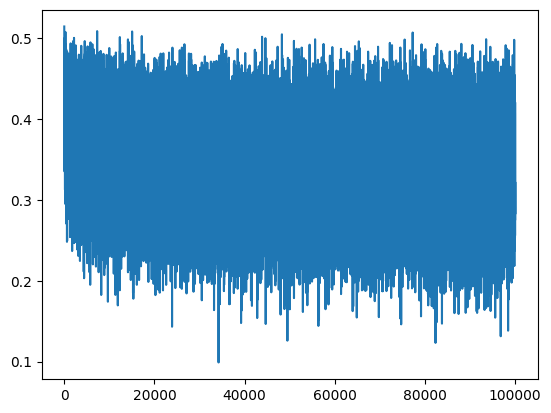

In [50]:
plt.plot(lossi)

In [51]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (x_train, y_train),
        'val': (x_val, y_val),
        'test': (x_test, y_test)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.size(0), -1)
    h = torch.tanh(embcat @ W1 + B1)
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')
    

train 2.180690050125122
val 2.2376396656036377
